## Proovedores de Internet en Argentina 

> Análisis de las quejas realizadas por usuarios de Twitter hacia los distintos proveedores de internet de la República Argentina. Todo este análisis se realiza con el fin de poder derterminar cual es el que tiene menos quejas en relación con la can

### 1. Primero realizamos la conexión entre Python y SQL Server 

In [1]:
import pyodbc
import sqlalchemy as sal
from sqlalchemy import create_engine
import pandas as pd
server = 'hxsqldev02\sql2016'
database = 'Academy_Dev_Data_RFlor'
driver = 'SQL Server'
engine = sal.create_engine(f'mssql://{server}/{database}?driver={driver}')
conn = engine.connect()
print(engine.table_names())

['dim_dates', 'dim_times', 'dim_users', 'dim_wifi_providers', 'fact_quotes', 'fact_replies', 'fact_retweets', 'fact_tweets', 'locations', 'raw_tweets', 'temporary_table', 'trips']


<ipython-input-1-674a419c6e52>:10: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


### 2. Realizamos un análisis de Pareto para tomar las empresas con mayor presencia en el mercado

> El análisis de Pareto consiste en quedarse con, en este caso los proveedores, que concentran la mayor cantidad de quejas. Esta regla también es conocida como 80-20, explicando que el 80% de los problemas surjen de solo el 20% de la población.

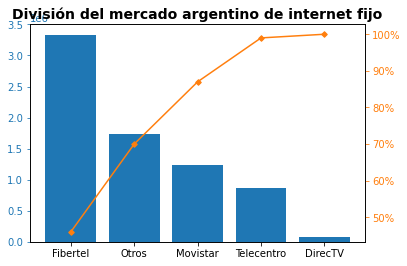

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

total = 7248280
fib_tot = 0.46*total
mov_tot = 0.17*total
tele_tot = 0.12*total
direc_tot = 0.01*total
otros_tot = 0.24*total

df = pd.DataFrame({'wp_num_users': [fib_tot, mov_tot, tele_tot, direc_tot, otros_tot]})
df.index = ['Fibertel', 'Movistar', 'Telecentro', 'DirecTV', 'Otros']
df = df.sort_values(by='wp_num_users',ascending=False)
df["cumpercentage"] = df["wp_num_users"].cumsum()/df["wp_num_users"].sum()*100


fig, ax = plt.subplots()
ax.bar(df.index, df["wp_num_users"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

plt.title('División del mercado argentino de internet fijo', fontsize = 14, fontweight='bold')
plt.show()

> Como se nota, hay 3 empresas que copan la mayoría del mercercado. Luego en la sección de 'otros' se encuentran empresas que trabajan en sectores puntuales y no vienen al caso de nuestro análisis.

>La fuente de los datos de porcentaje de mercado es de un informe de CABASE del año 2019, y del total de acceso a internet de un informe del INDEC.

>https://www.cabase.org.ar/wp-content/uploads/2019/12/CABASE-Internet-Index-II-Semestre-2019.pdf
>https://www.indec.gob.ar/uploads/informesdeprensa/internet_06_2134513C3A01.pdf

### 3. Aplicación de NLTK

> Realizamos un análisis de severidad de las quejas realizadas por los usuarios para intentar conocer un poco más el grado de enojo de los mismos. 

>Esto lo hacemos a través del uso de  NLTK, la cual es un conjunto de bibliotecas y programas para el procesamiento del lenguaje natural (PLN) simbólico y estadísticos para Python.